# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

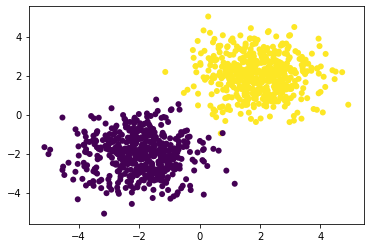

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = MSECriterion()

print(net)

# Test something like that then 

#net = Sequential()
#net.add(Linear(2, 4))
#net.add(ReLU())
#net.add(Linear(4, 2))
#net.add(ReLU())
# net.add(LogSoftMax())


Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

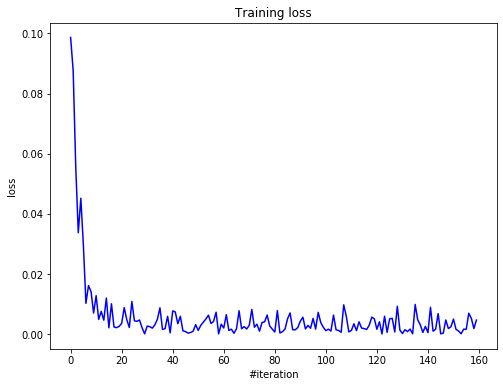

Current loss: 0.004674


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
import pandas as pd
y = y.astype(int)
y = pd.get_dummies(y).values

In [11]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000, 10)


- **Compare** `ReLU`, ~~`ELU`, `LeakyReLU`, `SoftPlus`~~ **`Sigmoid`** activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- ~~Hint: logloss for MNIST should be around 0.5.~~ 

In [12]:
# Your code goes here. ################################################
def trainLoop(X, Y, net, n_epoch, criterion, optimizer_config, optimizer_state):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      

            loss_history.append(loss)   

        return loss_history

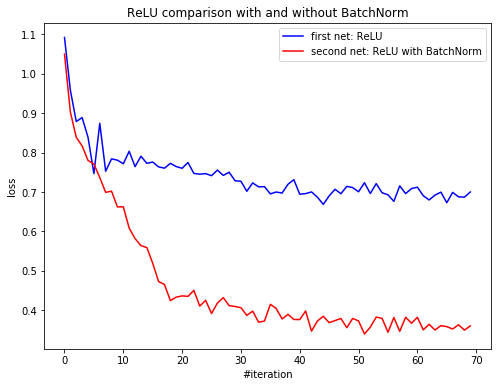

Min loss for first net (ReLU without BatchNorm): 0.668614
Min loss for second net (ReLU with BatchNorm): 0.340303


In [13]:
# we have ReLU and Sigmoid activation funcs
# run ReLU

# Iptimizer params
optimizer_config = {'learning_rate': 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 1000

net1 = Sequential()
net1.add(Linear(784, 10))
net1.add(ReLU())

loss_history1 = trainLoop(X, y, net1, n_epoch, criterion, 
                          optimizer_config, optimizer_state)

net2 = Sequential()
net2.add(Linear(784, 10))
net2.add(BatchNormalization(0.2))
net2.add(ChannelwiseScaling(10))
net2.add(ReLU())


loss_history2 = trainLoop(X, y, net2, n_epoch, criterion, 
                          optimizer_config, optimizer_state)

# Visualize

plt.figure(figsize=(8, 6))

plt.title("ReLU comparison with and without BatchNorm")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history1, 'b')
plt.plot(loss_history2, 'r')
plt.legend(labels=['first net: ReLU', 'second net: ReLU with BatchNorm'])
plt.show()

print('Min loss for first net (ReLU without BatchNorm): %f' % np.min(loss_history1))
print('Min loss for second net (ReLU with BatchNorm): %f' % np.min(loss_history2))

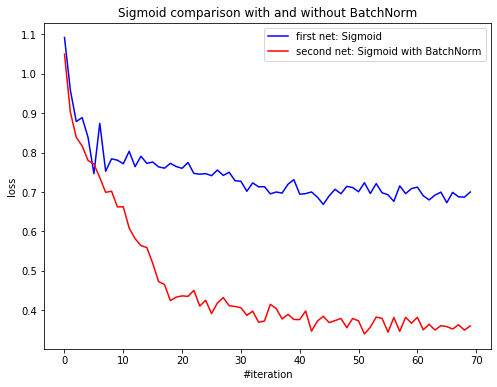

Min loss for third net (Sigmoid without BatchNorm): 0.804531
Min loss for fourth net (Sigmoid with BatchNorm): 0.273575


In [14]:
# we have ReLU and Sigmoid activation funcs
# run Sigmoid

net3 = Sequential()
net3.add(Linear(784, 10))
net3.add(Sigmoid())

loss_history3 = trainLoop(X, y, net3, n_epoch, criterion, 
                          optimizer_config, optimizer_state)

net4 = Sequential()
net4.add(Linear(784, 10))
net4.add(BatchNormalization(0.2))
net4.add(ChannelwiseScaling(10))
net4.add(Sigmoid())


loss_history4 = trainLoop(X, y, net4, n_epoch, criterion, 
                          optimizer_config, optimizer_state)

# Visualize

plt.figure(figsize=(8, 6))

plt.title("Sigmoid comparison with and without BatchNorm")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history1, 'b')
plt.plot(loss_history2, 'r')
plt.legend(labels=['first net: Sigmoid', 'second net: Sigmoid with BatchNorm'])
plt.show()

print('Min loss for third net (Sigmoid without BatchNorm): %f' % np.min(loss_history3))
print('Min loss for fourth net (Sigmoid with BatchNorm): %f' % np.min(loss_history4))

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [15]:
# Your code goes here. ################################################
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

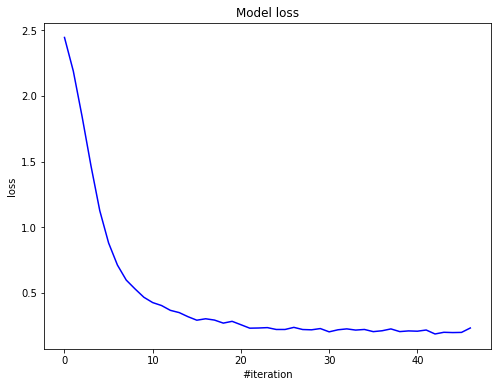

Min loss for model: 0.187653


In [17]:
# Iptimizer params
optimizer_config = {'learning_rate': 5e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 30
batch_size = 1000

model = Sequential()

model.add(Linear(784, 10))
model.add(BatchNormalization(0.3))
model.add(ChannelwiseScaling(10))
model.add(Sigmoid())



model.train()
loss_history_model = trainLoop(X_train, y_train, model, n_epoch, criterion, 
                               optimizer_config, optimizer_state)

# Visualize

plt.figure(figsize=(8, 6))

plt.title("Model loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history_model, 'b')
plt.show()

print('Min loss for model: %f' % np.min(loss_history_model))

Print here your accuracy. It should be around 90%.

In [18]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score

model.evaluate()
pred_test = model.forward(X_test) # probabilities
classes = np.argmax(pred_test, axis = 1)
pred = np.array([classes == i for i in range(10)]).T.astype(float) #one-hot
print("Accuracy: " + str(accuracy_score(y_test, pred)))

Accuracy: 0.8936363636363637
